# Modeling and Simulation in Python

Chapter 3

Completed by: Mael Illien

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim library
from modsim import *

# set the random number generator
np.random.seed(7)

## More than one State object

Here's the code from the previous chapter, with two changes:

1. I've added DocStrings that explain what each function does, and what parameters it takes.

2. I've added a parameter named `state` to the functions so they work with whatever `State` object we give them, instead of always using `bikeshare`.  That makes it possible to work with more than one `State` object.

In [2]:
def step(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)
        
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    state.olin -= 1
    state.wellesley += 1
    
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    state.wellesley -= 1
    state.olin += 1
    
def decorate_bikeshare():
    """Add a title and label the axes."""
    decorate(title='Olin-Wellesley Bikeshare',
             xlabel='Time step (min)', 
             ylabel='Number of bikes')

And here's `run_simulation`, which is a solution to the exercise at the end of the previous notebook.

In [3]:
def run_simulation(state, p1, p2, num_steps):
    """Simulate the given number of time steps.
    
    state: State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    num_steps: number of time steps
    """
    results = TimeSeries()    
    for i in range(num_steps):
        step(state, p1, p2)
        results[i] = state.olin
        
    plot(results, label='Olin')

Now we can create more than one `State` object:

In [4]:
bikeshare1 = State(olin=10, wellesley=2)

,values
olin,10
wellesley,2


In [5]:
bikeshare2 = State(olin=2, wellesley=10)

,values
olin,2
wellesley,10


Whenever we call a function, we indicate which `State` object to work with:

In [6]:
bike_to_olin(bikeshare1)

In [7]:
bike_to_wellesley(bikeshare2)

And you can confirm that the different objects are getting updated independently:

In [8]:
bikeshare1

,values
olin,11
wellesley,1


In [9]:
bikeshare2

,values
olin,1
wellesley,11


## Negative bikes

In the code we have so far, the number of bikes at one of the locations can go negative, and the number of bikes at the other location can exceed the actual number of bikes in the system.

If you run this simulation a few times, it happens often.

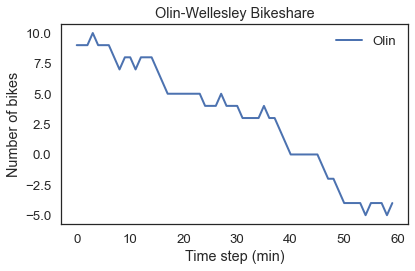

In [10]:
bikeshare = State(olin=10, wellesley=2)
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

We can fix this problem using the `return` statement to exit the function early if an update would cause negative bikes.

In [11]:
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    if state.olin == 0:
        return
    state.olin -= 1
    state.wellesley += 1
    
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    if state.wellesley == 0:
        return
    state.wellesley -= 1
    state.olin += 1

Now if you run the simulation again, it should behave.

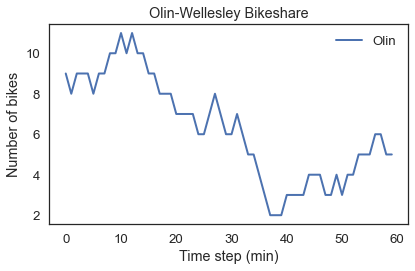

In [12]:
bikeshare = State(olin=10, wellesley=2)
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

## Comparison operators

The `if` statements in the previous section used the comparison operator `==`.  The other comparison operators are listed in the book.

It is easy to confuse the comparison operator `==` with the assignment operator `=`.

Remember that `=` creates a variable or gives an existing variable a new value.

In [13]:
x = 5

5

Whereas `==` compares two values and returns `True` if they are equal.

In [14]:
x == 5

True

You can use `==` in an `if` statement.

In [15]:
if x == 5:
    print('yes, x is 5')

yes, x is 5


But if you use `=` in an `if` statement, you get an error.

In [16]:
# If you remove the # from the if statement and run it, you'll get
# SyntaxError: invalid syntax

#if x = 5:
#    print('yes, x is 5')

**Exercise:** Add an `else` clause to the `if` statement above, and print an appropriate message.

Replace the `==` operator with one or two of the other comparison operators, and confirm they do what you expect.

In [17]:
if x == 5:
    print('yes, x is 5')
else:
    print('no, x is not 5')

yes, x is 5


In [18]:
if x < 5:
    print('yes, x less than 5')
else:
    print('no, x is greater or equal to 5')

no, x is greater or equal to 5


## Metrics

Now that we have a working simulation, we'll use it to evaluate alternative designs and see how good or bad they are.  The metric we'll use is the number of customers who arrive and find no bikes available, which might indicate a design problem.

First we'll make a new `State` object that creates and initializes additional state variables to keep track of the metrics.

In [19]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0)

,values
olin,10
wellesley,2
olin_empty,0
wellesley_empty,0


Next we need versions of `bike_to_wellesley` and `bike_to_olin` that update the metrics.

In [20]:
def bike_to_wellesley(state):
    """Move one bike from Olin to Wellesley.
    
    state: bikeshare State object
    """
    if state.olin == 0:
        state.olin_empty += 1
        return
    state.olin -= 1
    state.wellesley += 1
    
def bike_to_olin(state):
    """Move one bike from Wellesley to Olin.
    
    state: bikeshare State object
    """
    if state.wellesley == 0:
        state.wellesley_empty += 1
        return
    state.wellesley -= 1
    state.olin += 1

Now when we run a simulation, it keeps track of unhappy customers.

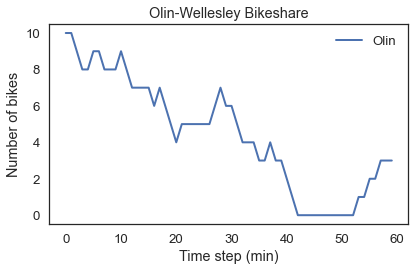

In [21]:
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

After the simulation, we can print the number of unhappy customers at each location.

In [22]:
bikeshare.olin_empty

6

In [23]:
bikeshare.wellesley_empty

0

## Exercises

**Exercise:** As another metric, we might be interested in the time until the first customer arrives and doesn't find a bike.  To make that work, we have to add a "clock" to keep track of how many time steps have elapsed:

1. Create a new `State` object with an additional state variable, `clock`, initialized to 0. 

2. Write a modified version of `step` that adds one to the clock each time it is invoked.

Test your code by running the simulation and check the value of `clock` at the end.

In [24]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,
                  clock=0)

,values
olin,10
wellesley,2
olin_empty,0
wellesley_empty,0
clock,0


In [25]:
def step(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    state.clock +=1
    
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)

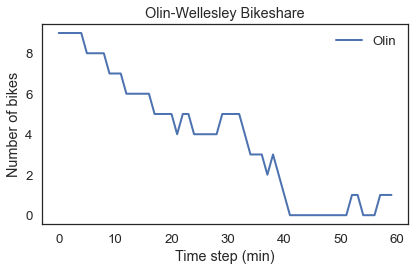

In [26]:
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

In [27]:
bikeshare.clock

60

**Exercise:** Continuing the previous exercise, let's record the time when the first customer arrives and doesn't find a bike.

1. Create a new `State` object with an additional state variable, `t_first_empty`, initialized to -1 as a special value to indicate that it has not been set. 

2. Write a modified version of `step` that checks whether`olin_empty` and `wellesley_empty` are 0.  If not, it should set `t_first_empty` to `clock` (but only if `t_first_empty` has not already been set).

Test your code by running the simulation and printing the values of `olin_empty`, `wellesley_empty`, and `t_first_empty` at the end.

In [34]:
bikeshare = State(olin=10, wellesley=2, 
                  olin_empty=0, wellesley_empty=0,
                  clock=0, t_first_empty=-1)

,values
olin,10
wellesley,2
olin_empty,0
wellesley_empty,0
clock,0
t_first_empty,-1


In [35]:
def step(state, p1, p2):
    """Simulate one minute of time.
    
    state: bikeshare State object
    p1: probability of an Olin->Wellesley customer arrival
    p2: probability of a Wellesley->Olin customer arrival
    """
    state.clock +=1
    
    if (state.olin_empty == 0 or state.wellesley_empty == 0) and state.t_first_empty == -1:
        state.t_first_empty = state.clock
    
    if flip(p1):
        bike_to_wellesley(state)
    
    if flip(p2):
        bike_to_olin(state)

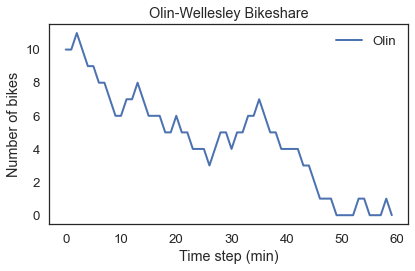

In [36]:
run_simulation(bikeshare, 0.4, 0.2, 60)
decorate_bikeshare()

In [37]:
bikeshare.olin_empty

4

In [38]:
bikeshare.wellesley_empty

0

In [39]:
bikeshare.t_first_empty

1